In [89]:
import pandas as pd

import io
import os
import re
import shutil
import string
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS
import wordcloud

from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN, GRU, LSTM, GlobalAveragePooling1D
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# DATASET & EDA

In [140]:
df_train= pd.read_csv('train.csv')
df_test=pd.read_csv('test.csv')

##### BASICS STATS

In [3]:
# Basic stats
print("Number of rows : {}".format(df_train.shape[0]))
print()

print("Display of dataset: ")
display(df_train.head())
print()

print("Basics statistics: ")
data_desc = df_train.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")
display(100*df_train.isnull().sum()/df_train.shape[0])

Number of rows : 7613

Display of dataset: 


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1



Basics statistics: 


,id,keyword,location,text,target
count,7613.000000,7552,5080,7613,7613.00000
unique,NaN,221,3341,7503,NaN
top,NaN,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...,NaN
freq,NaN,45,104,10,NaN
mean,5441.934848,NaN,NaN,NaN,0.42966
std,3137.116090,NaN,NaN,NaN,0.49506
min,1.000000,NaN,NaN,NaN,0.00000
25%,2734.000000,NaN,NaN,NaN,0.00000
50%,5408.000000,NaN,NaN,NaN,0.00000
75%,8146.000000,NaN,NaN,NaN,1.00000



Percentage of missing values: 


id           0.000000
keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64

In [91]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)

# Expanding Contractions in the reviews
df_train['text']=df_train['text'].apply(lambda x:expand_contractions(x))
df_test['text']=df_test['text'].apply(lambda x:expand_contractions(x))

##### PLOTS

In [5]:
#Exemple of real disaster & not real disaster:
print('Is a real disaster: {}'.format(df_train[df_train['target'] == 1].iloc[0,3]))
print('Is not a real disaster: {}'.format(df_train[df_train['target'] == 0].iloc[0,3]))

Is a real disaster: Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Is not a real disaster: What is up man?


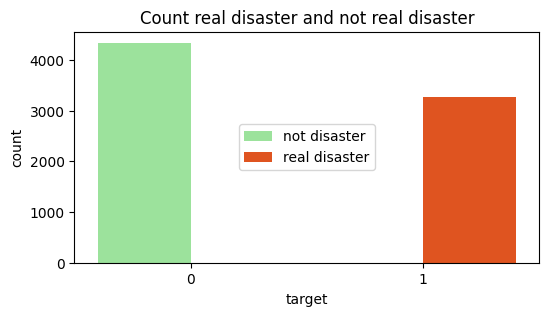

In [6]:
palette ={0:"lightgreen",1:"orangered"}
sns.countplot(data= df_train, x='target', hue='target', palette=palette).set(title='Count real disaster and not real disaster');
plt.gcf().set_size_inches(6, 3);
plt.legend(loc='center', labels=['not disaster', 'real disaster']);

##### WORDCLOUD

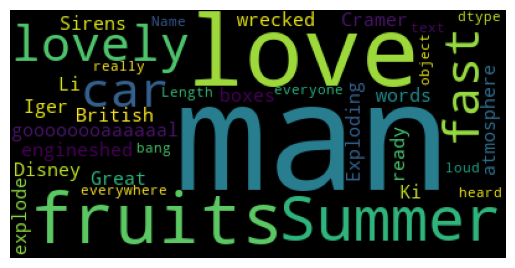

In [7]:
# Wordcloud for not real disaster:

# Instanciate WordCloud with no stop words
wd = wordcloud.WordCloud(stopwords=STOPWORDS)
not_real_disaster = df_train[df_train['target'] == 0]
text = str(not_real_disaster['text'])
# Generate word cloud 
cloud = wd.generate(text)

plt.imshow(cloud)
plt.axis("off")
plt.show()

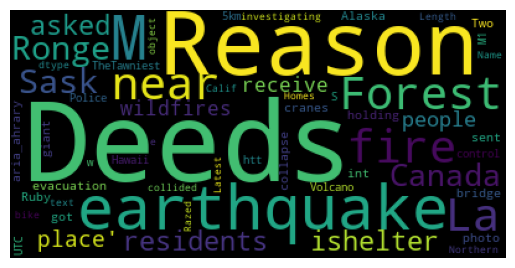

In [8]:
# Wordcloud for real disaster:

# Instanciate WordCloud with no stop words
wd = wordcloud.WordCloud(stopwords=STOPWORDS)
real_disaster = df_train[df_train['target'] == 1]
text = str(real_disaster['text'])
# Generate word cloud 
cloud = wd.generate(text)

plt.imshow(cloud)
plt.axis("off")
plt.show()

##### WORDS PER TWEET

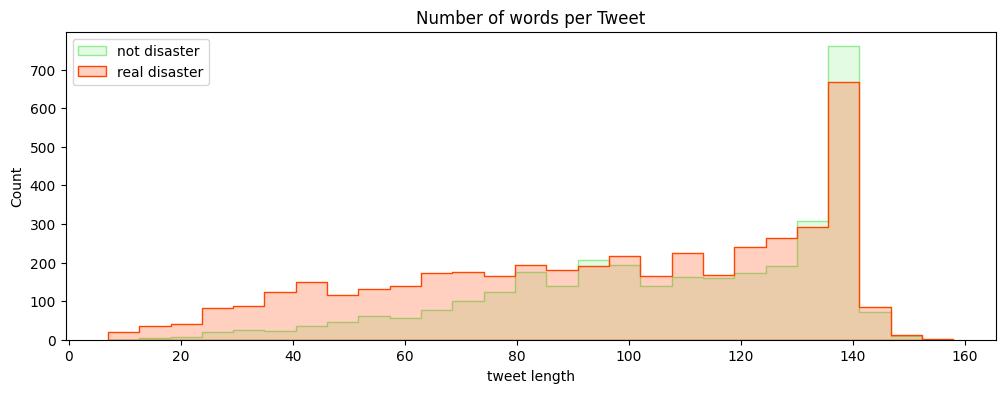

In [9]:
# Number of words per tweet:

df_train['tweet length'] = df_train['text'].apply(len)
palette ={0:"orangered",1:"lightgreen"}
g = sns.histplot(data=df_train, x='tweet length', hue='target', element='step', palette= palette).set(title='Number of words per Tweet');
plt.legend(loc='upper left', labels=['not disaster', 'real disaster'])
plt.gcf().set_size_inches(12, 4)
plt.show(g)

In [10]:
#STOPWORDS PER TWEET
import en_core_web_sm
nlp = en_core_web_sm.load()
from spacy.lang.en.stop_words import STOP_WORDS

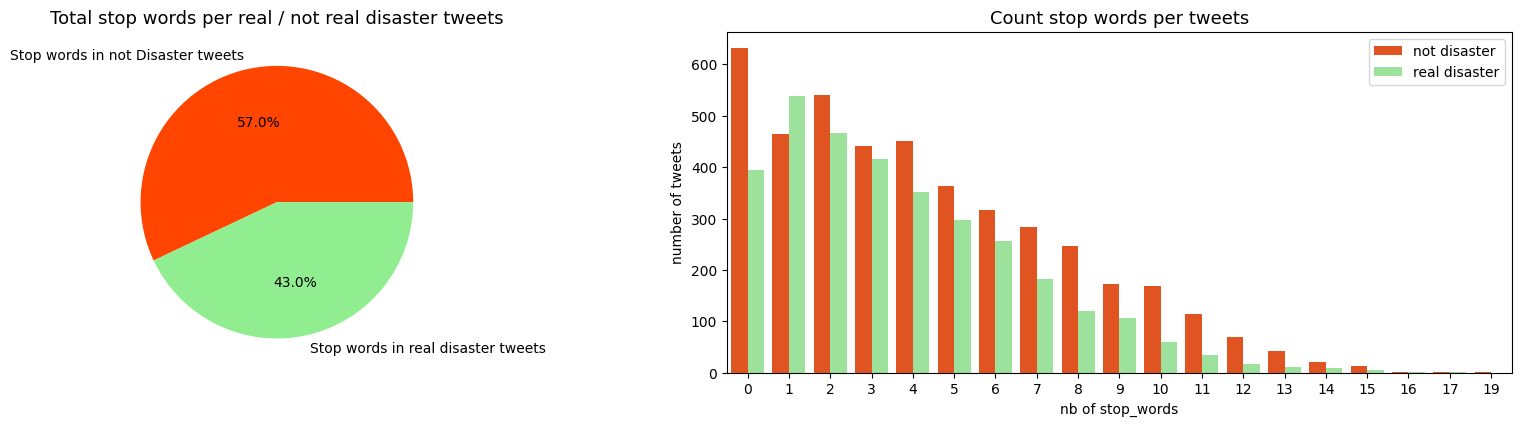

In [11]:
df_train["text_token"] = df_train["text"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x)]))
df_train['nb of stop_words'] = df_train['text'].str.split().apply(lambda x: len(set(x) & STOP_WORDS))

fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
plt.tight_layout()

palette ={0:"orangered",1:"lightgreen"}
labels=[0,1]
df_train.groupby('target').count()['nb of stop_words'].plot(kind='pie', autopct='%1.1f%%', ax=axes[0], colors= [palette[key] for key in labels[0:]], labels=['Stop words in not Disaster tweets', 'Stop words in real disaster tweets']);
sns.countplot(x=df_train['nb of stop_words'], hue=df_train['target'], palette= palette, ax=axes[1]);
plt.legend(loc='upper right', labels=['not disaster', 'real disaster']);

axes[0].set_ylabel('');
axes[1].set_ylabel('');
axes[0].set_title('Total stop words per real / not real disaster tweets', fontsize=13);
axes[1].set_title('Count stop words per tweets', fontsize=13);
axes[1].set_ylabel('number of tweets');


In [12]:
# EMOJIS
import advertools as adv
emoji_summary_train = adv.extract_emoji(df_train['text'])
emoji_summary_test = adv.extract_emoji(df_test['text'])
print('use of emojis in df_train:{}'.format(emoji_summary_train['top_emoji']))
print('use of emojis in df_test:{}'.format(emoji_summary_test['top_emoji']))

use of emojis in df_train:[('©', 10)]
use of emojis in df_test:[('©', 4)]


# PREPROCESSING TWEETS

In [141]:
# Remove url:
df_train["text_clean"] = df_train["text"].apply(lambda x: re.split('http:\/\/.*', str(x))[0])
df_test["text_clean"] = df_test["text"].apply(lambda x: re.split('http:\/\/.*', str(x))[0])
# Remove all non alphanumeric characters except whitespaces:
df_train["text_clean"] = df_train["text"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" "))
df_test["text_clean"] = df_test["text"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" "))
# replace double whitespaces with single whitespaces, convert all characters to lowercase and trim starting and finishing whitespaces.
df_train["text_clean"] = df_train["text_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
df_test["text_clean"] = df_test["text_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
# remove stop words and replace everyword with their lemma
df_train["text_clean"] = df_train["text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))
df_test["text_clean"] = df_test["text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))

In [142]:
# Frequency words across tweets:
from collections import Counter

#target = 1
df_target_1 = df_train[df_train['target'] == 1]
list_all_words = str(df_target_1.apply(lambda row: row['text_clean'], axis=1).to_list())
split_words = re.findall(r'\w+', list_all_words )
counter = Counter(split_words)
counter_df_real = pd.DataFrame(list(counter.items()),columns=['Words', 'Frequency'])
counter_df_real = counter_df_real.sort_values(by='Frequency',ascending=False).reset_index(drop=True).head(15)

#target = 0
df_target_0 = df_train[df_train['target'] == 0]
list_all_words = str(df_target_0.apply(lambda row: row['text_clean'], axis=1).to_list())
split_words = re.findall(r'\w+', list_all_words )
counter = Counter(split_words)
counter_df_not_real = pd.DataFrame(list(counter.items()),columns=['Words', 'Frequency'])
counter_df_not_real = counter_df_not_real.sort_values(by='Frequency',ascending=False).reset_index(drop=True).head(15)

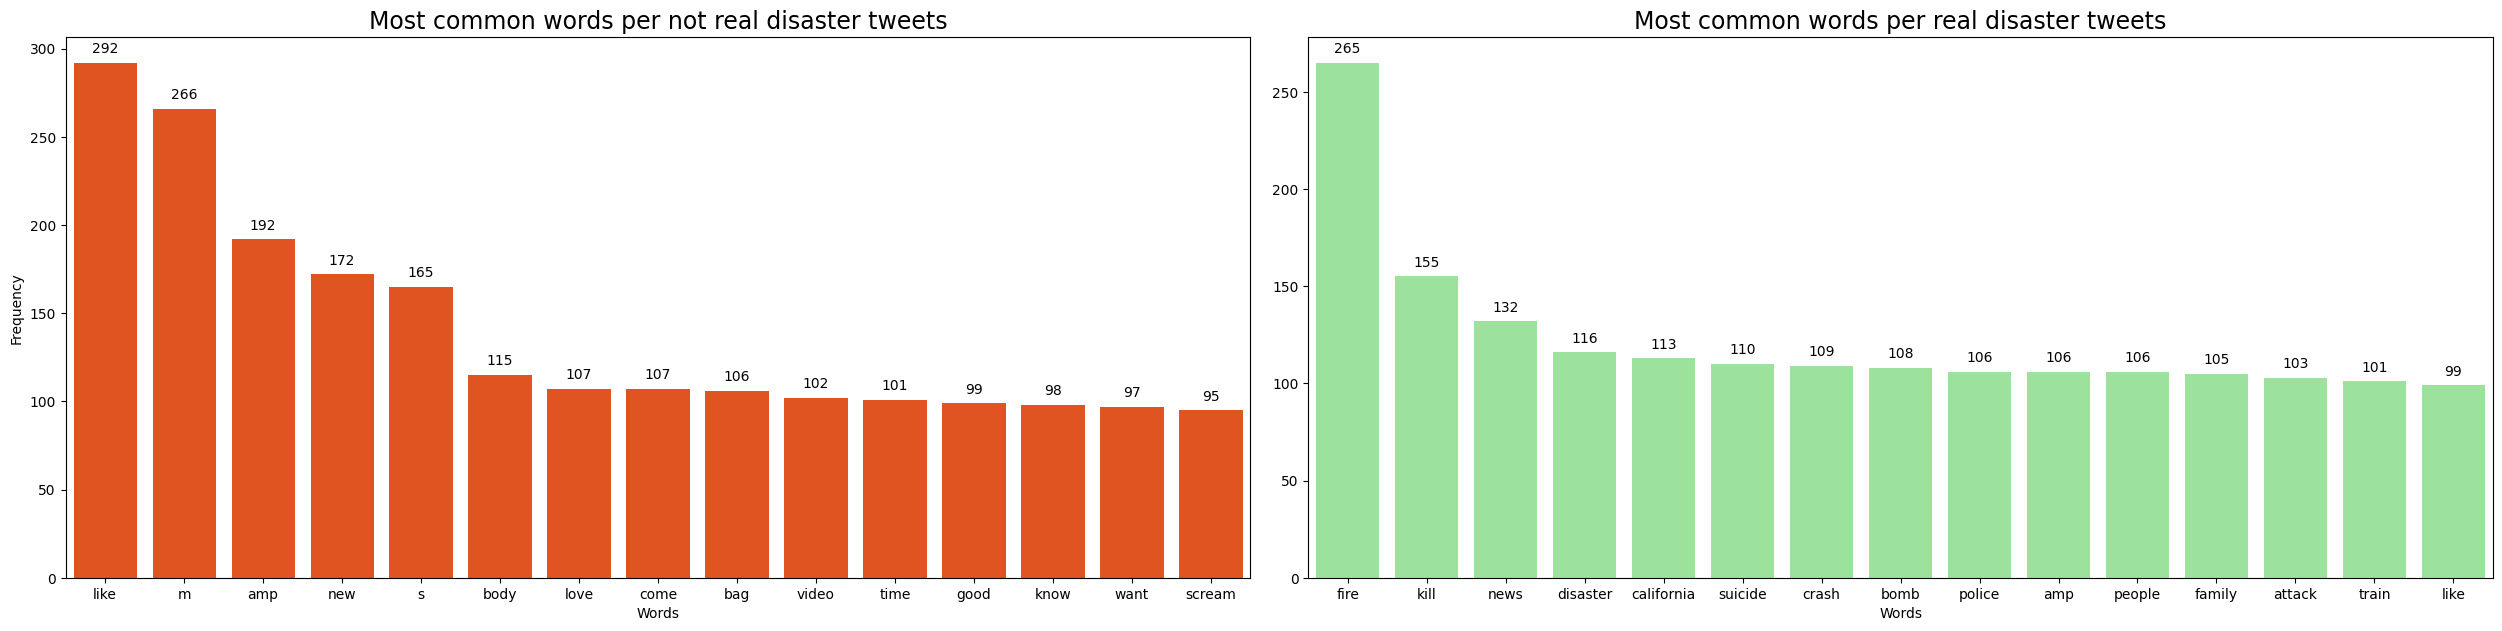

In [143]:
fig, axes = plt.subplots(ncols=2, figsize=(25, 6), dpi=100)
plt.tight_layout()

sns.barplot(data=counter_df_not_real, y='Frequency', x='Words', orient='v', color = 'orangered', ax=axes[0])
sns.barplot(data=counter_df_real, y='Frequency', x='Words', orient='v', color = 'lightgreen', ax=axes[1]);

axes[0].set_title('Most common words per not real disaster tweets', fontsize=17);
axes[1].set_title('Most common words per real disaster tweets', fontsize=17);
axes[1].set_ylabel('')

for p in axes[1].patches:
    axes[1].annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
for p in axes[0].patches:
    axes[0].annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

In [144]:
tokenizer_train = tf.keras.preprocessing.text.Tokenizer(num_words=1000, oov_token="out_of_vocab") # instanciate the tokenizer
tokenizer_train.fit_on_texts(df_train.text_clean)
df_train["text_encoded"] = tokenizer_train.texts_to_sequences(df_train.text_clean)
df_train["len_text"] = df_train["text_encoded"].apply(lambda x: len(x))
df_train = df_train[df_train["len_text"]!=0]

tokenizer_test = tf.keras.preprocessing.text.Tokenizer(num_words=1000, oov_token="out_of_vocab") # instanciate the tokenizer
tokenizer_test.fit_on_texts(df_test.text_clean)
df_test["text_encoded"] = tokenizer_test.texts_to_sequences(df_test.text_clean)
df_test["len_text"] = df_test["text_encoded"].apply(lambda x: len(x))
df_test = df_test[df_test["len_text"]!=0]

In [145]:
train_pad = tf.keras.preprocessing.sequence.pad_sequences(df_train.text_encoded, padding="post")
test_pad = tf.keras.preprocessing.sequence.pad_sequences(df_test.text_encoded, padding="post")

In [146]:
# Train Test Split
X_train, X_val, y_train, y_val = train_test_split(train_pad,df_train['target'], test_size=0.3, random_state=42)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_val.shape)

# We'll use this to form a tensorflow dataset containing on the one hand
# the encoded texts and the labels.
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val = tf.data.Dataset.from_tensor_slices((X_val, y_val))

# We then organize the dataste per batch and we shuffle
train_batch = train.shuffle(len(train)).batch(512)
val_batch = val.shuffle(len(val)).batch(512)
# Let's see a batch 
for text, target in train_batch.take(1):
  print(text, target)

Shape of train (5329, 25)
Shape of Validation  (2284, 25)
tf.Tensor(
[[669   1  82 ...   0   0   0]
 [211 119   4 ...   0   0   0]
 [  1   1  41 ...   0   0   0]
 ...
 [418   1 502 ...   0   0   0]
 [  1   1   1 ...   0   0   0]
 [401  27   0 ...   0   0   0]], shape=(512, 25), dtype=int32) tf.Tensor(
[0 1 0 1 0 1 0 0 1 0 1 1 0 0 1 0 1 0 1 0 0 0 1 1 0 0 1 1 0 1 1 1 0 0 0 1 0
 1 1 0 0 1 1 0 1 0 0 1 1 1 1 0 1 0 0 0 0 0 1 1 0 1 1 0 1 0 0 0 0 1 1 1 1 1
 0 1 0 1 1 1 1 1 0 0 1 1 1 0 1 0 1 0 1 0 1 1 1 0 0 0 0 1 1 0 0 0 1 0 1 1 1
 1 0 0 1 0 1 0 1 0 1 1 0 0 0 0 1 1 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 1 0 1 1 0
 0 0 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 1 0 1 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 1
 1 0 0 0 0 0 1 1 1 1 0 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 0 1 0 1 0 1 1 1 0 0 1 0 1 0 0 1 1 0 1 0 1 1 0 1 0 0 0 0 1 1 0 0
 0 0 1 0 1 0 0 0 1 1 1 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 0 0 1 0 1 1
 0 1 0 0 0 0 1 0 1 0 0 1 1 0 1 0 1 1 1 0 0 1 0 0 1 1 0 1 0 1 1 0 1 0 0 1 0
 0 1 1 0 0 0 1 0 1 1 1

# MODELING & EVALUATION

In [147]:
from tensorflow import keras

##### SIMPLE RNN WITH ACCURACY

In [148]:
vocab_size = len(tokenizer_train.word_index)
model_simpleRNN = tf.keras.Sequential([
                  # Word Embedding layer           
                  Embedding(vocab_size+1, 64, input_shape=[text.shape[1],],name="embedding"),
                  
                  SimpleRNN(units=64, return_sequences=True), # maintains the sequential nature
                  SimpleRNN(units=32, return_sequences=False), # returns the last output
                  # Dense layers once the data is flat
                  Dense(16, activation='relu'),
                  Dense(8, activation='relu'),

                  # output layer with as many neurons as the number of classes
                  # for the target variable and softmax activation
                  Dense(1, activation="sigmoid")
])

In [149]:
model_simpleRNN.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [150]:
# Model training 
simpleRNN_history = model_simpleRNN.fit(train_batch,
                              epochs=20, 
                              validation_data=val_batch)
val_loss_simple_RNN, val_acc_simple_RNN = model_simpleRNN.evaluate(X_val, y_val)
print('Val accuracy simple_RNN:', val_acc_simple_RNN)
print('Val loss simple_RNN:', val_loss_simple_RNN)

Epoch 1/20
11/11 [==============================] - 2s 67ms/step - loss: 0.6611 - accuracy: 0.5915 - val_loss: 0.6425 - val_accuracy: 0.6388
Epoch 2/20
11/11 [==============================] - 0s 38ms/step - loss: 0.6052 - accuracy: 0.6983 - val_loss: 0.5878 - val_accuracy: 0.7167
Epoch 3/20
11/11 [==============================] - 0s 36ms/step - loss: 0.5088 - accuracy: 0.7816 - val_loss: 0.5552 - val_accuracy: 0.7478
Epoch 4/20
11/11 [==============================] - 0s 40ms/step - loss: 0.4293 - accuracy: 0.8223 - val_loss: 0.5453 - val_accuracy: 0.7426
Epoch 5/20
11/11 [==============================] - 0s 37ms/step - loss: 0.3748 - accuracy: 0.8531 - val_loss: 0.5526 - val_accuracy: 0.7382
Epoch 6/20
11/11 [==============================] - 0s 39ms/step - loss: 0.3219 - accuracy: 0.8773 - val_loss: 0.5694 - val_accuracy: 0.7404
Epoch 7/20
11/11 [==============================] - 0s 38ms/step - loss: 0.2803 - accuracy: 0.8972 - val_loss: 0.5914 - val_accuracy: 0.7491
Epoch 8/20
11

[]

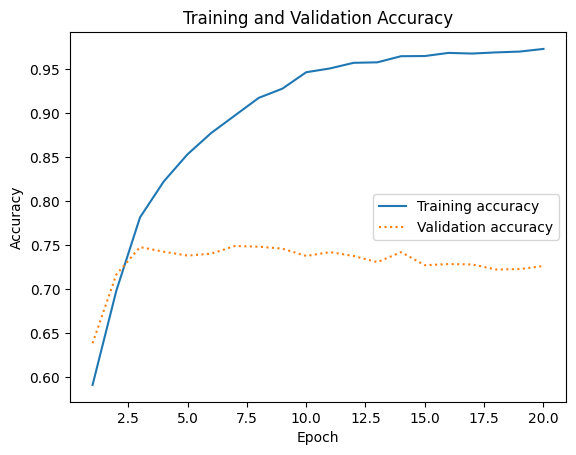

In [151]:
acc_simple_RNN = simpleRNN_history.history['accuracy']
val_simple_RNN = simpleRNN_history.history['val_accuracy']
epochs = range(1, len(acc_simple_RNN) + 1)

plt.plot(epochs, acc_simple_RNN, '-', label='Training accuracy');
plt.plot(epochs, val_simple_RNN, ':', label='Validation accuracy');
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='center right')
plt.plot()

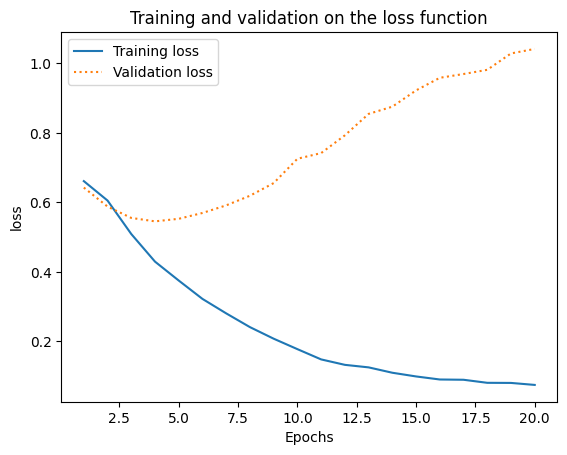

In [152]:
loss_simpleRNN = simpleRNN_history.history['loss']
val_loss_simpleRNN = simpleRNN_history.history['val_loss']
epochs = range(1, len(loss_simpleRNN) + 1)

plt.plot(epochs, loss_simpleRNN, '-', label='Training loss')
plt.plot(epochs, val_loss_simpleRNN, ':', label='Validation loss')
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.title('Training and validation on the loss function')
plt.legend()
plt.show()

##### MODEL GRU WITH ACCURACY

In [153]:
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, GRU, LSTM

vocab_size = len(tokenizer_train.word_index)
model_gru = tf.keras.Sequential([
                  Embedding(vocab_size+1, 64, input_shape=[text.shape[1],],name="embedding"),
                  GRU(units=64, return_sequences=True), # maintains the sequential nature
                  GRU(units=32, return_sequences=False), # returns the last output
                  Dense(16, activation='relu'),
                  Dense(8, activation='relu'),
                  Dense(1, activation="sigmoid")
])

In [154]:
model_gru.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 64)            1304384   
                                                                 
 gru_16 (GRU)                (None, 25, 64)            24960     
                                                                 
 gru_17 (GRU)                (None, 32)                9408      
                                                                 
 dense_38 (Dense)            (None, 16)                528       
                                                                 
 dense_39 (Dense)            (None, 8)                 136       
                                                                 
 dense_40 (Dense)            (None, 1)                 9         
                                                                 
Total params: 1,339,425
Trainable params: 1,339,425
N

In [155]:
model_gru.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [156]:
# Model training 
gru_history = model_gru.fit(train_batch,
                              epochs=20, 
                              validation_data=val_batch
)
val_loss_gru, val_acc_gru = model_gru.evaluate(X_val, y_val)
print('Val accuracy gru:', val_acc_gru)
print('Val loss gru:', val_loss_gru)

Epoch 1/20
11/11 [==============================] - 5s 182ms/step - loss: 0.6908 - accuracy: 0.5675 - val_loss: 0.6865 - val_accuracy: 0.5771
Epoch 2/20
11/11 [==============================] - 1s 83ms/step - loss: 0.6853 - accuracy: 0.5675 - val_loss: 0.6809 - val_accuracy: 0.5771
Epoch 3/20
11/11 [==============================] - 1s 81ms/step - loss: 0.6843 - accuracy: 0.5675 - val_loss: 0.6806 - val_accuracy: 0.5771
Epoch 4/20
11/11 [==============================] - 1s 79ms/step - loss: 0.6833 - accuracy: 0.5675 - val_loss: 0.6797 - val_accuracy: 0.5771
Epoch 5/20
11/11 [==============================] - 1s 89ms/step - loss: 0.6799 - accuracy: 0.5671 - val_loss: 0.6699 - val_accuracy: 0.5771
Epoch 6/20
11/11 [==============================] - 1s 109ms/step - loss: 0.6515 - accuracy: 0.6033 - val_loss: 0.5997 - val_accuracy: 0.6826
Epoch 7/20
11/11 [==============================] - 1s 111ms/step - loss: 0.5281 - accuracy: 0.7536 - val_loss: 0.5357 - val_accuracy: 0.7522
Epoch 8/20

[]

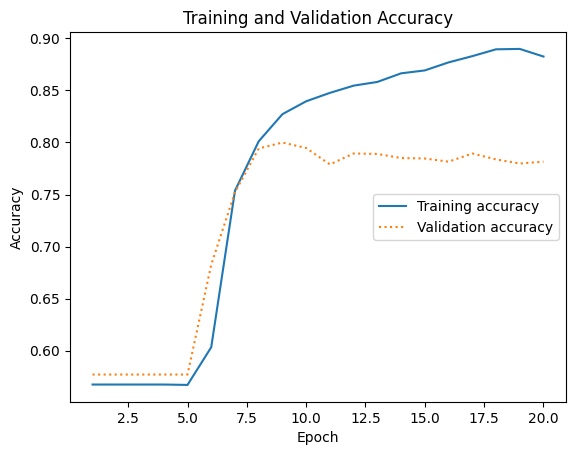

In [157]:
acc_gru = gru_history.history['accuracy']
val_gru = gru_history.history['val_accuracy']
epochs = range(1, len(acc_gru) + 1)

plt.plot(epochs, acc_gru, '-', label='Training accuracy');
plt.plot(epochs, val_gru, ':', label='Validation accuracy');
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='center right')
plt.plot()

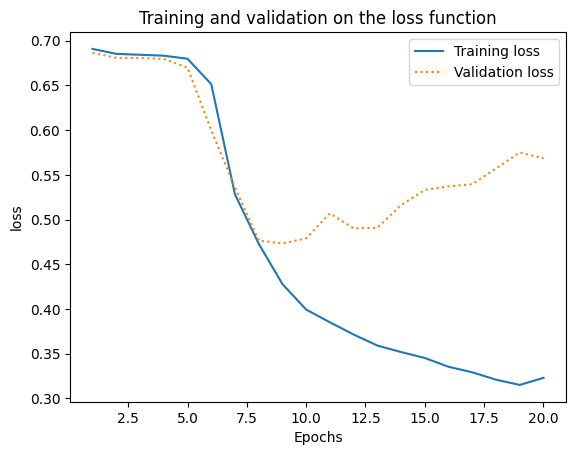

In [158]:
loss_gru = gru_history.history['loss']
val_loss_gru = gru_history.history['val_loss']
epochs = range(1, len(loss_gru) + 1)

plt.plot(epochs, loss_gru, '-', label='Training loss')
plt.plot(epochs, val_loss_gru, ':', label='Validation loss')
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.title('Training and validation on the loss function')
plt.legend()
plt.show()

##### MODEL LSTM WITH ACCURACY

In [161]:
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, GRU, LSTM

vocab_size = len(tokenizer_train.word_index)
model_lstm = tf.keras.Sequential([
                  Embedding(vocab_size+1, 64, input_shape=[text.shape[1],],name="embedding"),
                  LSTM(units=64, return_sequences=True), # maintains the sequential nature
                  LSTM(units=32, return_sequences=False), # returns the last output
                  Dense(16, activation='relu'),
                  Dense(8, activation='relu'),

                  Dense(1, activation="sigmoid", name="last")
])

In [162]:
model_lstm.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 64)            1304384   
                                                                 
 lstm_4 (LSTM)               (None, 25, 64)            33024     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dense_43 (Dense)            (None, 16)                528       
                                                                 
 dense_44 (Dense)            (None, 8)                 136       
                                                                 
 last (Dense)                (None, 1)                 9         
                                                                 
Total params: 1,350,497
Trainable params: 1,350,497
N

In [163]:
model_lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [164]:
lstm_history = model_lstm.fit(train_batch,
                              epochs=20, 
                              validation_data=val_batch
)
val_loss_lstm, val_acc_lstm = model_lstm.evaluate(X_val, y_val)
print('Val accuracy lstm:', val_acc_lstm)
print('Val loss lstm:', val_loss_lstm)

Epoch 1/20
11/11 [==============================] - 4s 150ms/step - loss: 0.6894 - accuracy: 0.5517 - val_loss: 0.6792 - val_accuracy: 0.5771
Epoch 2/20
11/11 [==============================] - 1s 94ms/step - loss: 0.6800 - accuracy: 0.5675 - val_loss: 0.6702 - val_accuracy: 0.5771
Epoch 3/20
11/11 [==============================] - 1s 96ms/step - loss: 0.6528 - accuracy: 0.5785 - val_loss: 0.6026 - val_accuracy: 0.7211
Epoch 4/20
11/11 [==============================] - 1s 101ms/step - loss: 0.5467 - accuracy: 0.7615 - val_loss: 0.5270 - val_accuracy: 0.7609
Epoch 5/20
11/11 [==============================] - 1s 109ms/step - loss: 0.4625 - accuracy: 0.8056 - val_loss: 0.4799 - val_accuracy: 0.7929
Epoch 6/20
11/11 [==============================] - 1s 119ms/step - loss: 0.4171 - accuracy: 0.8251 - val_loss: 0.4860 - val_accuracy: 0.7815
Epoch 7/20
11/11 [==============================] - 1s 127ms/step - loss: 0.3863 - accuracy: 0.8459 - val_loss: 0.4857 - val_accuracy: 0.7855
Epoch 8/

[]

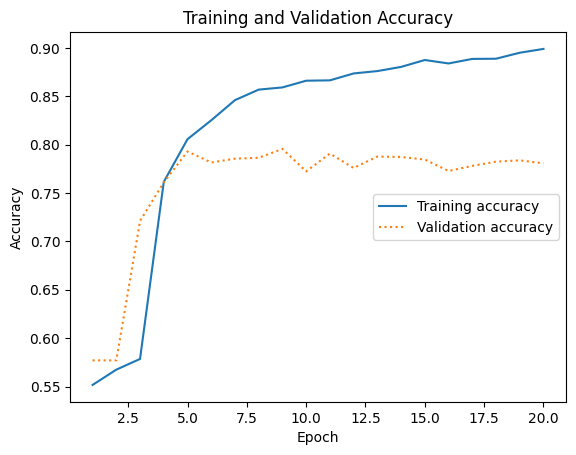

In [165]:
acc_lstm = lstm_history.history['accuracy']
val_lstm = lstm_history.history['val_accuracy']
epochs = range(1, len(acc_lstm) + 1)

plt.plot(epochs, acc_lstm, '-', label='Training accuracy');
plt.plot(epochs, val_lstm, ':', label='Validation accuracy');
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='center right')
plt.plot()

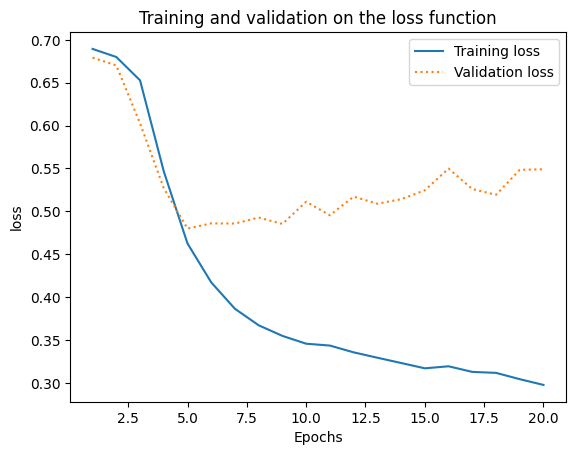

In [166]:
loss_lstm = lstm_history.history['loss']
val_loss_lstm = lstm_history.history['val_loss']
epochs = range(1, len(loss_lstm) + 1)

plt.plot(epochs, loss_lstm, '-', label='Training loss')
plt.plot(epochs, val_loss_lstm, ':', label='Validation loss')
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.title('Training and validation on the loss function')
plt.legend()
plt.show()

##### FOCUS ON GRU

In [177]:
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, GRU, LSTM

# We then organize the dataste per batch and we shuffle
train_batch = train.shuffle(len(train)).batch(64)
val_batch = val.shuffle(len(val)).batch(64)

vocab_size = len(tokenizer_train.word_index)
model_gru_test = tf.keras.Sequential([
                  Embedding(vocab_size+1, 64, input_shape=[text.shape[1],],name="embedding"),
                  GRU(units=64, return_sequences=True), # maintains the sequential nature
                  GRU(units=32, return_sequences=False), # returns the last output
                  Dense(16, activation='relu'),
                  Dense(8, activation='relu'),
                  Dense(1, activation="sigmoid")
])

In [178]:
model_gru_test.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [179]:
# Model training 

gru_history_test = model_gru_test.fit(train_batch,
                              epochs=8, 
                              validation_data=val_batch
                              )
val_loss_gru_test, val_acc_gru_test = model_gru_test.evaluate(X_val, y_val)
print('Val accuracy gru:', val_acc_gru_test)
print('Val loss gru:', val_loss_gru_test)

Epoch 1/8
84/84 [==============================] - 6s 32ms/step - loss: 0.6858 - accuracy: 0.5652 - val_loss: 0.6812 - val_accuracy: 0.5766
Epoch 2/8
84/84 [==============================] - 3s 30ms/step - loss: 0.5918 - accuracy: 0.6819 - val_loss: 0.4849 - val_accuracy: 0.7763
Epoch 3/8
84/84 [==============================] - 3s 34ms/step - loss: 0.4375 - accuracy: 0.8114 - val_loss: 0.4618 - val_accuracy: 0.7947
Epoch 4/8
84/84 [==============================] - 3s 33ms/step - loss: 0.4040 - accuracy: 0.8324 - val_loss: 0.4760 - val_accuracy: 0.7955
Epoch 5/8
84/84 [==============================] - 3s 34ms/step - loss: 0.3823 - accuracy: 0.8450 - val_loss: 0.4743 - val_accuracy: 0.7916
Epoch 6/8
84/84 [==============================] - 3s 34ms/step - loss: 0.3705 - accuracy: 0.8506 - val_loss: 0.4728 - val_accuracy: 0.7881
Epoch 7/8
84/84 [==============================] - 3s 34ms/step - loss: 0.3610 - accuracy: 0.8546 - val_loss: 0.4953 - val_accuracy: 0.7877
Epoch 8/8
72/72 [===

72/72 [==============================] - 0s 4ms/step


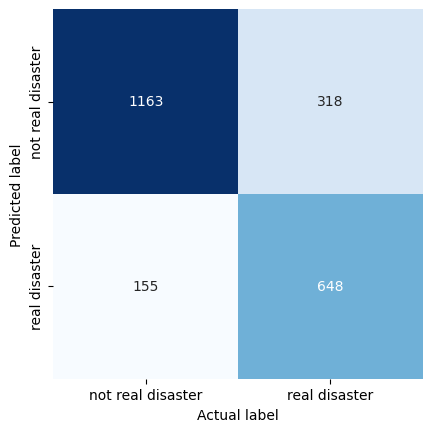

In [218]:
from sklearn.metrics import confusion_matrix

y_predicted = model_gru_test.predict(X_val) > 0.5
mat = confusion_matrix(y_predicted, y_val)
labels = ['not real disaster', 'real disaster']

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels);

plt.ylabel('Predicted label');
plt.xlabel('Actual label');

In [181]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

print('Precision: %.3f' % precision_score(y_val, y_predicted))
print('F1 Score: %.3f' % f1_score(y_val, y_predicted))
print('Recall Score: %.3f' % recall_score(y_val, y_predicted))
print('Accuracy Score:  %.3f' % accuracy_score(y_val, y_predicted))

Precision: 0.807
F1 Score: 0.733
Recall Score: 0.671
Accuracy Score:  0.793


##### PREDICTIONS ON DATA

In [212]:
y_test_pad = model_gru_test.predict(test_pad)
df_test['prediction'] = y_test_pad
df_test['prediction'] = [round(x) for x in df_test['prediction']]

102/102 [==============================] - 0s 3ms/step


In [215]:
df_test.drop(columns=['keyword','location', 'text_clean','text_encoded','len_text'])

,id,text,prediction
0,0,Just happened a terrible car crash,1
1,2,"Heard about #earthquake is different cities, s...",1
2,3,"there is a forest fire at spot pond, geese are...",0
3,9,Apocalypse lighting. #Spokane #wildfires,0
4,11,Typhoon Soudelor kills 28 in China and Taiwan,0
...,...,...,...
3258,10861,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,0
3259,10865,Storm in RI worse than last hurricane. My city...,0
3260,10868,Green Line derailment in Chicago http://t.co/U...,0
3261,10874,MEG issues Hazardous Weather Outlook (HWO) htt...,0


In [216]:
sample_submission_df = pd.read_csv('sample_submission.csv')
sample_submission_df = df_test[['id', 'prediction']]
sample_submission_df

,id,prediction
0,0,1
1,2,1
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0
